In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from loader import get_experiments
from strike_predictor.model import StrikePredictor, EXPERIMENTS_DIR

In [52]:
%%time
sp = StrikePredictor('/media/sil2/Data/regev/datasets/pogona_strikes3', segment_length=20, is_debug=False, n_epochs=50, infer_delay=3.0,
                     n_layers=5, hidden_dim=768, dropout=0.4, lr=1e-4)
sp.train();

CPU times: user 4min 49s, sys: 1.72 s, total: 4min 51s
Wall time: 23.7 s


0.9895833333333334

In [50]:
%%time
res = []
for segment_length in [20, 30, 50, 90]:
    for n_layers in [5, 15, 25]:
        for hidden_dim in [256, 512, 768]:
            for dropout in [0.2, 0.4, 0.6]:
                for lr in [1e-4, 1e-5, 1e-6]:
                    for n_epochs in [30, 50]:
                        sp = StrikePredictor('/media/sil2/Data/regev/datasets/pogona_strikes3', segment_length=segment_length, is_debug=False, n_epochs=n_epochs,
                                             n_layers=n_layers, hidden_dim=hidden_dim, dropout=dropout, lr=lr, is_save_model=False)
                        acc = sp.train()
                        res.append((acc, segment_length, n_layers, hidden_dim, dropout, lr, n_epochs))

res.sort(key=lambda x: x[0], reverse=True)

CPU times: user 2d 10h 58min 40s, sys: 39min 44s, total: 2d 11h 38min 24s
Wall time: 11h 58min 1s


In [1]:
import torch

torch.cuda.is_available()

True

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from pandas.plotting import table

prfs = precision_recall_fscore_support(np.array([0,1,3,2,2,0,0]), np.array([0,0,3,1,2,3,2]))
prfs = pd.DataFrame(prfs).transpose()
prfs.columns = ['precision', 'recall', 'fscore', 'support']
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, prfs)

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 15h 2min 43s, sys: 3min 54s, total: 15h 6min 38s
Wall time: 3h 18min 25s


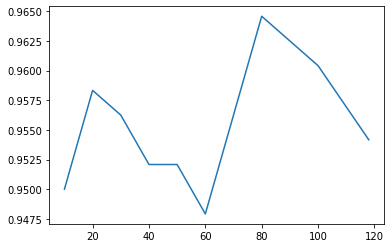

In [9]:
%%time
acc = []
N_REPEAT = 5
lengths = [10, 20, 30, 40, 50, 60, 80, 100, 118]
for l in tqdm(lengths):
    _acc = []
    for _ in range(N_REPEAT):
        sp = StrikePredictor('/media/sil2/Data/regev/datasets/pogona_strikes3', segment_length=l, is_debug=False)
        _acc.append(sp.train())
    acc.append(np.mean(_acc))

plt.plot(lengths, acc)

  0%|          | 0/8811 [00:00<?, ?it/s]

Embedding Duration: 21.5 ms
RNN Duration: 12.4 ms
Time taken for 8811 frames: 5.8 minutes


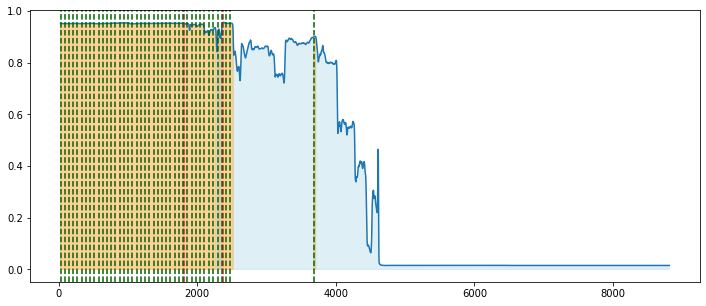

In [3]:
pred_df = sp.predict_video(f'{EXPERIMENTS_DIR}/9/20201021/block2/trial3/videos/realtime_20201021T105545.mp4')
sp.plot_predicted_video(pred_df)

In [5]:
all_strikes = pd.read_csv(f'{EXPERIMENTS_DIR}/all_strikes.csv', index_col=0)
vid_paths = [p.as_posix() for p in Path(EXPERIMENTS_DIR).rglob('realtime_*.mp4') if p.name in all_strikes.video_name.unique()]

In [ ]:
sp.is_debug = False
for i, p in enumerate(tqdm(vid_paths)):
    pred_df = sp.predict_video(p)
    sp.plot_predicted_video(pred_df)
    if i > 5:
        break

In [56]:
annot_df

,dirname,start_frame,end_frame,label
0,6_20201012_block2_trial3_4540,0,119,0
1,9_20201021_block3_trial1_2811,0,119,0
2,7_20201213_block1_trial3_1907,0,119,0
3,10_20201223_block13_trial1_5919,55,174,0
4,9_20201021_block3_trial1_6154,0,119,0
...,...,...,...,...
510,realtime_20201108T145842_strike2259,0,118,4
511,realtime_20201108T145842_strike6592,0,118,4
512,realtime_20201109T135947_strike277,0,118,4
513,realtime_20201109T135947_strike542,0,118,4


In [ ]:
n_frames = 7
DATASET_DIR = Path('/media/sil2/Data/regev/datasets/pogona_strikes3')
annot_df = pd.read_csv(f'{DATASET_DIR}/annotations.txt', delimiter=' ',
                       names=['dirname', 'start_frame', 'end_frame', 'label'])
dirs = [p for p in Path(DATASET_DIR).glob('*') if p.is_dir()]
n_rows = 50
for label in annot_df.label.unique():
    fig_id = 0
    label_dirs = [p for p in dirs if p.name in annot_df.query(f'label=={label}').dirname.values]
    for row, dirpath in enumerate(tqdm(label_dirs)):
        if (row % n_rows) == 0:
            fig, axes = plt.subplots(n_rows, n_frames, figsize=(30, 4*n_rows))
            fig.suptitle(f'Label {label}')
            fig.tight_layout()
            fig_id += 1
        row = row - fig_id * n_rows
        images = sorted(list(dirpath.glob('*.jpg')))[-n_frames:]
        for col, img_path in enumerate(images):
            frame = cv2.imread(img_path.as_posix())
            axes[row, col].imshow(frame)
            axes[row, col].axis('off')
            axes[row, col].margins(0, 0)
            if col == 0:
                axes[row, col].set_title(dirpath.name)

In [7]:

loaders = get_experiments('2020-10-01', '2021-01-29', experiment_dir=experiments_dir, num_of_strikes=1)

In [14]:
strikes_df = []
for ld in tqdm(loaders):
    try:
        hits_frames = sorted([x for x in ld.get_hits_frames() if x is not None])
        name = ld.get_video_path().name
        for i, strike_frame in enumerate(hits_frames):
            strikes_df.append({'video_name': name, 'strike_id': i, 'strike_frame': strike_frame,
                               'animal_id': ld.animal_id})
    except:
        continue

strikes_df = pd.DataFrame(strikes_df)
strikes_df.to_csv(f'{experiments_dir}/all_strikes.csv')

  0%|          | 0/227 [00:00<?, ?it/s]

In [23]:
sp.model_attributes

['train_dir',
 'segment_length',
 'is_save_embedding',
 'is_save_model',
 'threshold',
 'batch_size',
 'n_layers',
 'n_epochs',
 'hidden_dim',
 'dropout',
 'lr',
 'test_size',
 'is_debug']

'20220713T115706'

In [21]:
from torchvision import transforms, models
import torch.nn as nn

m = models.efficientnet_b4(pretrained=True)
m.eval()
module_list = list(m.children())
module_list[-2]

AdaptiveAvgPool2d(output_size=1)

In [23]:
x = torch.randn((1, 3, 224, 224))
conv5 = nn.Sequential(*module_list[:-2])
pool5 = module_list[-2]
x = pool5(conv5(x))
x.view(x.size(0), -1).size()

torch.Size([1, 1792])